# work flow on ZTF Ic-BL objects
### Collapsars as Sites of r-process Nucleosynthesis: Systematic Near-Infrared Follow-up of Type Ic-BL Supernovae (Anand et al, 2022)

In [1]:
from sdapy import snerun, functions, filters
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
from astropy.cosmology import Planck13 as cosmo
plt.rcParams["text.usetex"] = False

### ZTF names for the project

In [2]:
snlist = ['ZTF18acpeekw', 'ZTF18acbwxcc', 'ZTF18acaimrb',
          'ZTF18abklarx', 'ZTF20aazkjfv', 'ZTF21aafnunh',
          'ZTF18acqphpd', 'ZTF18aczqzrj', 'ZTF19aawqcgy',
          'ZTF19aaxfcpq', 'ZTF19ablesob', 'ZTF19abzwaen',
          'ZTF20abswdbg', 'ZTF20aapcbmc', 'ZTF20abbplei',
          'ZTF20abzoeiw', 'ZTF21aadatfg', 'ZTF21aagtpro',
          'ZTF21abmjgwf', 'ZTF21acbnfos',
          'ZTF19adaiomg', 'ZTF18abukavn', 'ZTF20aalxlis',
         ]

### Velocities from Shreya

In [3]:
velocities = {}
velfile = '/Users/yash0613/Desktop/singleobj_study/ztficbl/absolute_velocities_IcBL_Shreya.txt'
for nn,ll in enumerate(open(velfile).readlines()):
    if nn == 0:continue
    snname = ll.split()[0]
    snphase = float(ll.split()[1])
    tempphase = float(ll.split()[2])
    v = float(ll.split()[3])
    verr = float(ll.split()[4])
    velocities[snname] = [snphase,v,verr]

### start snelist

In [4]:
ztfp = snerun.snelist()
ztfp.parse_meta(
    withnew='new',
    metafile='rcf_query.txt',
    syntax='objid in %s'%snlist)

meta 23 objs


In [15]:
snenames = dict()
ztfnames = []
snenames['SN2018gep'] = 0.032
snenames['SN2018jaw'] = 0.047
snenames['SN2018kva'] = 0.043
snenames['SN2019gwc'] = 0.038
snenames['SN2019hsx'] = 0.021
snenames['SN2019moc'] = 0.056
snenames['SN2019qfi'] = 0.029
snenames['SN2019xcc'] = 0.029
snenames['GRB190829A'] = 0.077
snenames['SN2020bvc'] = 0.025
snenames['SN2020dgd'] = 0.03
snenames['SN2020lao'] = 0.031
snenames['SN2020rph'] = 0.042
snenames['SN2020tkx'] = 0.027
snenames['SN2021bmf'] = 0.017
snenames['SN2021xv'] = 0.041
snenames['SN2021ywf'] = 0.028
snenames['SN2021too'] = 0.035
for objid in snenames:
    _q = ztfp.meta.query('alias==@objid')
    if len(_q) == 0: 
        print (objid)
        continue
    ztfid = _q.index[0]
    ztfp.meta['z'][ztfid] = snenames[objid]
    ztfnames.append(ztfid)

GRB190829A


mbolbb not available yet
no nir detection found for ZTF18abukavn, skipped...
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
no nir detection found for ZTF20aapcbmc, skipped...
mbolbb not available yet
no nir detection found for ZTF20abbplei, skipped...
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet


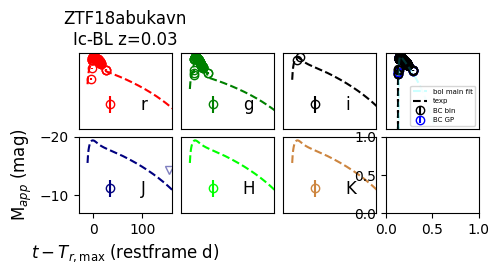

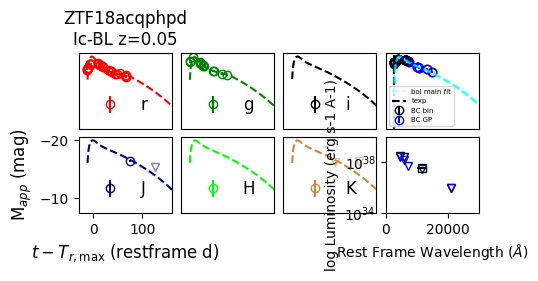

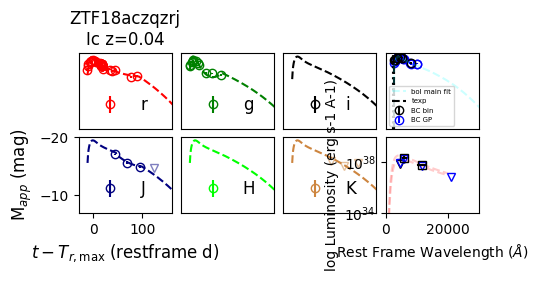

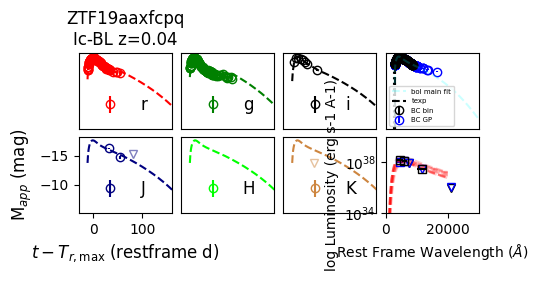

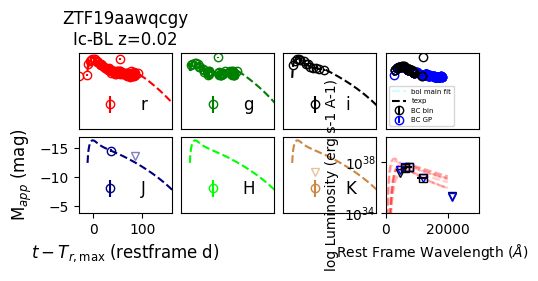

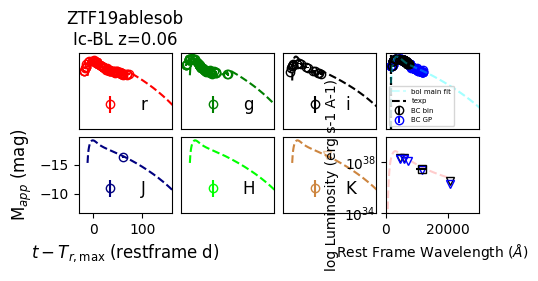

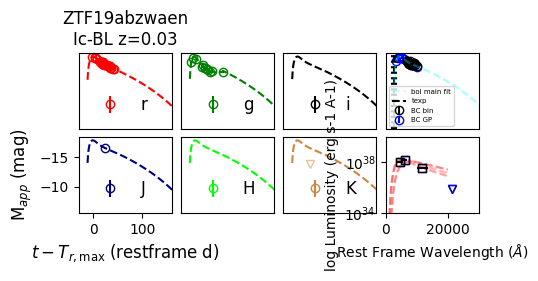

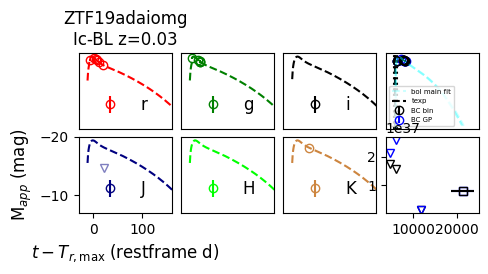

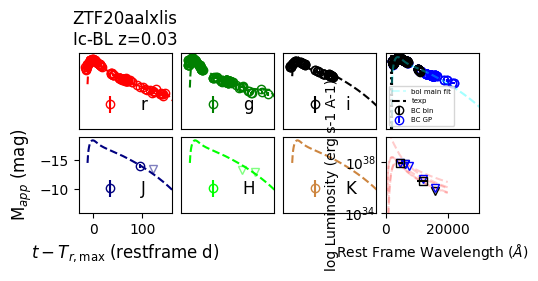

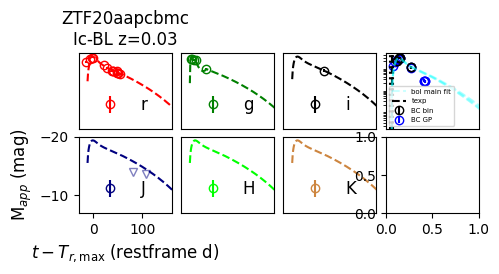

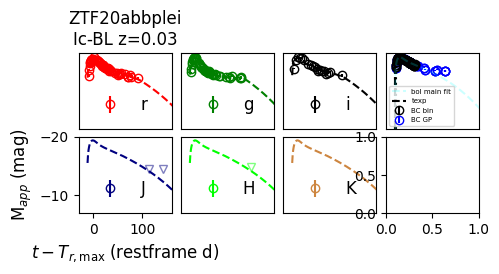

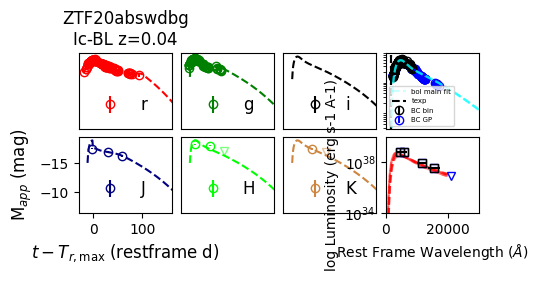

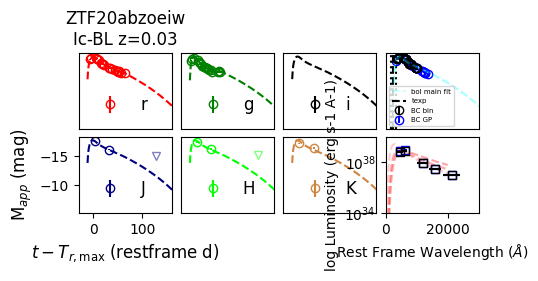

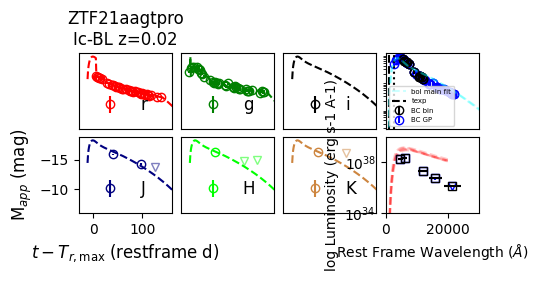

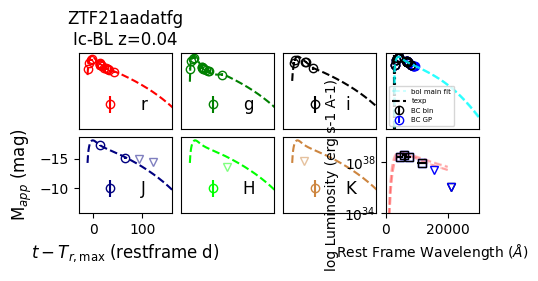

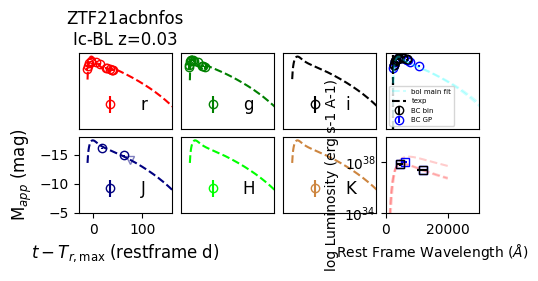

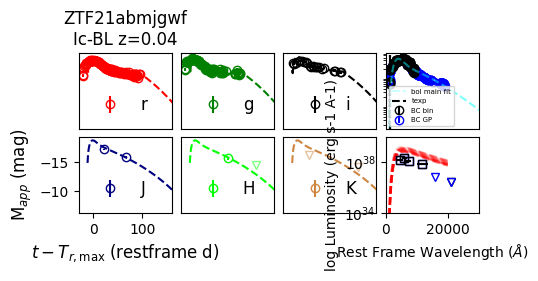

In [202]:
from scipy import integrate
from scipy.optimize import curve_fit

def bol_to_m(ztfp, objid, ax, filt, showax=False, show_title=False, show_limits=False):
    ztfp.data[objid].ax2 = ax
    ztfp.data[objid]._ax2(
        ax_ystyle='app', ax_xstyle='rp', show_gp=False,
        plot_bands=[filt], show_title=show_title, show_legend=True, show_fit_error=True,
        label=filt, show_limits=show_limits, alphasample=.5, alphabest=1
    )
    phase = ztfp.data[objid].lc.query('mag<99 and filter == @filt')['jdobs'].to_list() - ztfp.data[objid].t0
    mag = np.array(ztfp.data[objid].lc.query('mag<99 and filter == @filt')['mag'].to_list()) - ztfp.data[objid].dm
    _xx, _yy = [], []
    for _x, _y in zip(phase, mag):
        __ = np.argmin(abs(jds-_x))
        bc = _y - filters.Rf[filt]*ztfp.data[objid].mkwebv - functions.Lbol_to_Mbol(mbols)[__]
        if bc < -999: continue
        _xx.append(_x)
        _yy.append(bc)
    if len(_xx) == 0: 
        ztfp.data[objid].ax2.plot(
            jds, functions.Lbol_to_Mbol(mbols) + 0, ls='--',color=filters.PROP1[filt]['color']
        )
    elif len(_xx) <= 2:
        ztfp.data[objid].ax2.plot(
            jds, functions.Lbol_to_Mbol(mbols) + np.mean(_yy), ls='--',color=filters.PROP1[filt]['color']
        )
    else:
        def func(x,a,b,c): return a*x**2+b*x+c
        params, covar = curve_fit(func, _xx, _yy, method='trf', maxfev=20000)            
        perr = np.sqrt(np.diag(covar))
        _xl, _yl = [], []
        for __jd, __mbol in zip(jds,mbols):
            if __jd>=min(_xx) and __jd<=max(_xx):  # interpolate
                _xl.append(__jd)
                _yl.append(functions.Lbol_to_Mbol(__mbol) + func(__jd, *params))
            else: # otherwise constant bc
                _xl.append(__jd)
                _yl.append(functions.Lbol_to_Mbol(__mbol) + func(max(_xx), *params))
        ztfp.data[objid].ax2.plot(
            _xl, _yl, ls='--',color=filters.PROP1[filt]['color']
        )
    if not showax:
        ax.set_xlabel('')
        ax.set_xticks([])
        ax.set_ylabel('')
        ax.set_yticks([])
    ax.set_xlim([-30, 160])
    
for nn, objid in enumerate(ztfnames):
    
    # for single object
    ztfp.parse_meta_all(ztfp.kwargs, objid)
    if ztfp.sntype is None: ztfp.sntype = 'Ic-BL'
    
    ztfp.data[objid] = snerun.snobject(objid, z=ztfp.z, ra=ztfp.ra, dec=ztfp.dec,
                mkwebv=ztfp.mkwebv, hostebv=ztfp.hostebv, sntype=ztfp.sntype.replace('?',''),
                dm=ztfp.dm, jdpeak=ztfp.jdpeak)
    
    # get ZTf forced phot from local
    ztfp.data[objid].get_fp_ztf()
    
    # get NIR phot from local
    if not os.path.exists('ZTF_NIR_photometry/%s_phot_table.txt'%objid): 
        print ('no nir phot found for %s, skipped...' % objid)
        continue
    ztfp.data[objid].get_external_phot('ZTF_NIR_photometry/%s_phot_table.txt'%objid, source='nir')
    
    # run GP
    ztfp.data[objid].run_gp(gp_bands=['r','g','i','J','H','K'])
    ztfp.data[objid].set_peak_gp('r')
    
    # set texp
    ztfp.data[objid].set_texp_midway()
    texp = ztfp.data[objid].texp[1]
    
    # run Arnett fits
    ztfp.data[objid].lyman_bol()
    ztfp.data[objid].run_fit('bol_main', fit_methods=['arnett_fit_taum'], 
                             bol_main_xrangep=[texp,200], fit_redo=True)
    '''
    jds, mbols = None, None
    for source in ztfp.data[objid].fitcls['bol_main']:
        for model in ztfp.data[objid].fitcls['bol_main'][source]:
            _model = ztfp.data[objid].fitcls['bol_main'][source][model]                        
            x, y, y1, y2, f = _model.predict(x_pred=None, step = 1, returnv=True, quant=[.5,.5,.5])
            jds = (x-ztfp.data[objid].t0) / (1+ztfp.data[objid].z)
            mbols = y
    if jds is None: 
        print ('no mbol for %s' % objid)
        continue
    '''
    
    # show them
    ztfp.data[objid].fig, axes = plt.subplots(2,4,figsize=(5,2), dpi=100)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)
    
    # flux plot
    bol_to_m(ztfp, objid, axes[0,0], 'r', show_title=True)
    bol_to_m(ztfp, objid, axes[0,1], 'g')
    bol_to_m(ztfp, objid, axes[0,2], 'i')
    bol_to_m(ztfp, objid, axes[1,0], 'J', showax=True, show_limits=True)
    bol_to_m(ztfp, objid, axes[1,1], 'H', show_limits=True)
    bol_to_m(ztfp, objid, axes[1,2], 'K', show_limits=True)
    
    ztfp.data[objid].ax4 = axes[0,3]
    ztfp.data[objid]._ax4()
    ztfp.data[objid].ax4.set_xlabel('')
    ztfp.data[objid].ax4.set_xticks([])
    ztfp.data[objid].ax4.set_ylabel('')
    ztfp.data[objid].ax4.set_yticks([])
    ztfp.data[objid].ax4.set_xlim([-30, 160])
    ztfp.data[objid].ax4.legend(fontsize=5)
    
    if len(ztfp.data[objid].lc.query('mag<99 and filter in ["J", "H", "K"]')) == 0: 
        print ('no nir detection found for %s, skipped...' % objid)
        continue
    #ztfp.data[objid].run_fit('sed', fit_methods=['bb'], make_bol=['bb'])
    ztfp.data[objid].bb_bol(fastsedfitting=True, make_bol=['bb'])
    ztfp.data[objid].ax5 = axes[1,3]
    phase = (ztfp.data[objid].lc.query('mag<99 and filter in ["J", "H", "K"]')['jdobs'].to_list()[0] - ztfp.data[objid].t0)
    try:
        ztfp.data[objid]._ax5(phase, sed_bands=['g','r','i','J','H','K'], tdbin=5, 
                          ax5_xlim=[0,30000], ax5_ylim=[1e34,1e40], show_fits=True)
    except:
        pass

In [127]:
literature_obj = dict()
literature_obj['SN1998bw'] = 0.06
literature_obj['SN2002ap'] = 0.09
literature_obj['SN2007ce'] = 0.00
literature_obj['SN2007I'] = 0.34
literature_obj['SN2009bb'] = 0.540
literature_obj['SN2010bh'] = 0.30
literature_obj['SN2016coi'] = 0.00
sncls = snerun.snelist()
sncls.parse_meta(
    withnew='new',
    source='OAC',
    syntax='objid in %s'%list(literature_obj.keys()),
    verbose=False,
)

mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet
mbolbb not available yet


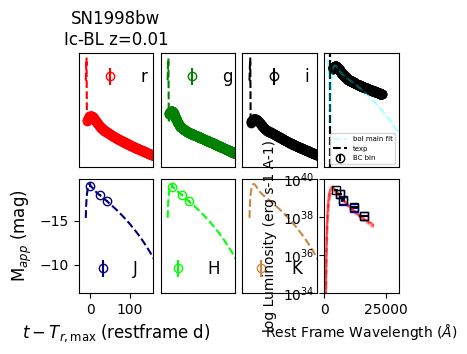

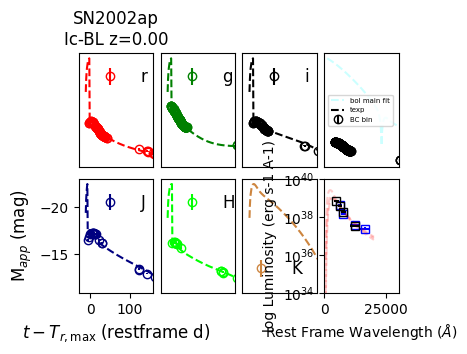

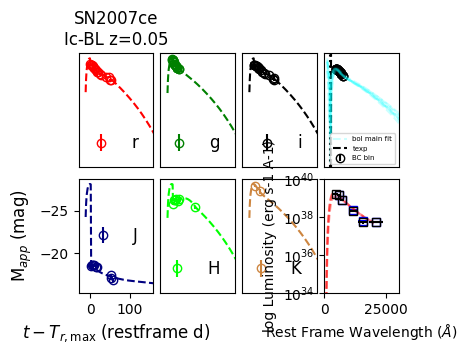

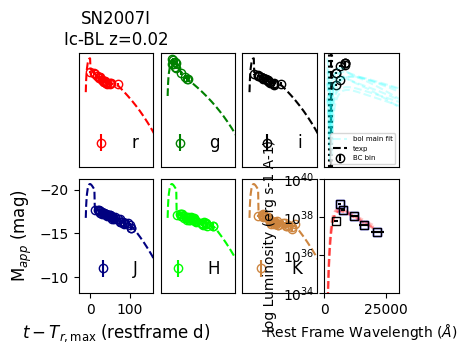

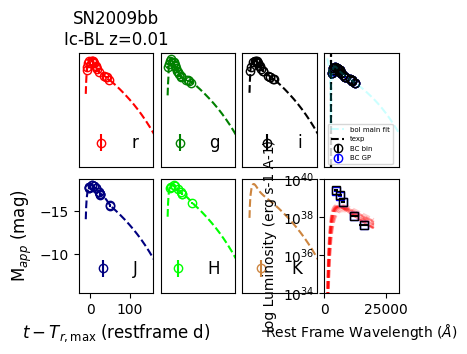

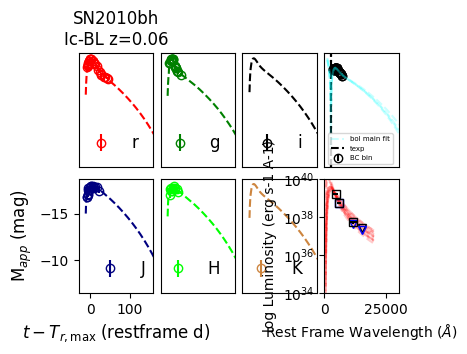

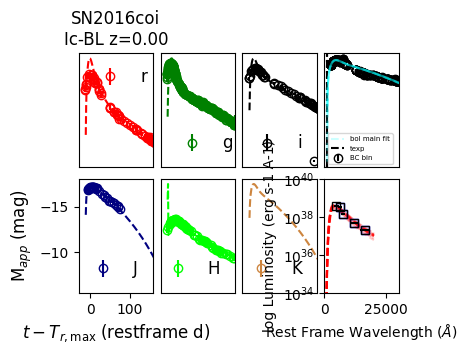

In [205]:
def change_filter(sncls, f='g'):
    '''
    g = V + 0.630 *(B - V) - 0.124
    r = g - 1.646 * (V - R) + 0.139 = V + 0.630 *(B - V) - 0.124 - 1.646 * (V - R) + 0.139
    i = I + 0.247 * (R - I) + 0.329
    '''
    assert f in ['r', 'g', 'i']
    assert 'B' in np.unique(sncls.lc['filter'])
    assert 'V' in np.unique(sncls.lc['filter'])
    if f == 'r': assert 'R' in np.unique(sncls.lc['filter'])
    if f == 'g':
        def func(f1, f2, _func, ff):
            _df = sncls.lc.query('filter==@f1')
            jds = _df['jdobs'].to_numpy()
            m1, m1e = _df['mag'].to_numpy(), _df['emag'].to_numpy()
            _xpred = list(_df['jdobs'] - sncls.t0)
            m2, m2e = sncls._mag_at_list(f2, _xpred, interpolation='gp', index=0)
            for _p,_m1,_m2,_m1e,_m2e in zip(jds,m1,m2,m1e,m2e):
                if _m1 is None or _m1e is None or _m2 is None or _m2e is None: continue
                _mg = _func(_m1, _m2)
                _emg = np.sqrt(_m1e**2+_m2e**2)
                _df = pd.DataFrame([[_p, _mg, _emg, ff, 'blahblah']], columns=['jdobs', 'mag', 'emag', 'filter', 'source'])
                sncls.lc = sncls.lc.append(_df, ignore_index=True)
        def _func(m1,m2): return m1 + 0.630 *(m2 - m1) - 0.124
        func('V', 'B', _func, 'g')
        def _func(m1,m2): return m2 + 0.630 *(m1 - m2) - 0.124
        func('B', 'V', _func, 'g')
    elif f == 'r':
        def func(f1, f2, f3, _func, ff):
            _df = sncls.lc.query('filter==@f1')
            jds = _df['jdobs'].to_numpy()
            m1, m1e = _df['mag'].to_numpy(), _df['emag'].to_numpy()
            _xpred = list(_df['jdobs'] - sncls.t0)
            m2, m2e = sncls._mag_at_list(f2, _xpred, interpolation='gp', index=0)
            m3, m3e = sncls._mag_at_list(f3, _xpred, interpolation='gp', index=0)
            for _p,_m1,_m2,_m1e,_m2e,_m3,_m3e in zip(jds,m1,m2,m3,m1e,m2e,m3e):
                if _m1 is None or _m1e is None or _m2 is None or _m2e is None or _m3 is None or _m3e is None: continue
                _mg = _func(_m1, _m2, _m3)
                _emg = np.sqrt(_m1e**2+_m2e**2+_m3e**2)
                _df = pd.DataFrame([[_p, _mg, _emg, ff, 'blahblah']], columns=['jdobs', 'mag', 'emag', 'filter', 'source'])
                sncls.lc = sncls.lc.append(_df, ignore_index=True)
        def _func(m1,m2,m3): return m1 + 0.630 *(m2 - m1) - 0.124 - 1.646 * (m1 - m3) + 0.139
        func('V', 'B', 'R', _func, 'r')

ys=dict()
ys['SN2007ce'] = 0
for objid in literature_obj:
    
    hostebv = literature_obj[objid]
    
    # for single object
    sncls.parse_meta_all(sncls.kwargs, objid)
    sncls.sntype = 'Ic-BL'
    sncls.data[objid] = snerun.snobject(objid, z=sncls.z, ra=sncls.ra, dec=sncls.dec,
                mkwebv=sncls.mkwebv, hostebv=hostebv, sntype=sncls.sntype,
                dm=sncls.dm, jdpeak=sncls.jdpeak)
    
    if objid in ['SN2007ce', 'SN2007I', 'SN2009bb']:
        # get lcs from oac
        sncls.data[objid].get_oac(which='photometry')
        
        # correct ebv
        mm = []
        for f in sncls.data[objid].lc['filter']:
            mm.append(filters.Rf[f] * (sncls.data[objid].mkwebv+sncls.data[objid].hostebv))
        sncls.data[objid].lc['mag'] += mm
        
        # run GP
        sncls.data[objid].run_gp(gp_bands=np.unique(sncls.data[objid].lc['filter']))
        sncls.data[objid].set_peak_gp('r')
    
        t0 = sncls.data[objid].t0
        
        # introduce BV from OAC
        sncls.data[objid].lc = sncls.data[objid].lc.query('filter in ["B", "V"]')
    else:
        t0 = 2459000
        
    # get lcs from local
    filename = 'literature_lcs/%s.txt'%objid
    _ = []
    for nn,ll in enumerate(open(filename, encoding='utf-8').readlines()):
        if ll[0]=='#' or len(ll)==0:_.append(nn)
    df = pd.read_csv(filename,skiprows=_,delim_whitespace=True)
    df = df.query('emag > -99')
    df['mag'] += sncls.dm
    df['jdobs'] += t0
    sncls.data[objid].mkwebv = 0
    sncls.data[objid].hostebv = 0
    sncls.data[objid].add_lc(df, source='blah')
    sncls.data[objid].add_flux(source='blah')
    
    # run GP
    sncls.data[objid].run_gp(gp_bands=np.unique(sncls.data[objid].lc['filter']))
    sncls.data[objid].set_peak_gp('r')
    
    if False:
        # plot
        fig, ax = plt.subplots(1,1,figsize=(6,6))
        ax.invert_yaxis()
        _lc = sncls.data[objid].lc.query('source=="blah"')
        for f in np.unique(_lc['filter']):
            if f not in filters.PROP1:
                print (f)
                continue
            __lc = _lc.query('filter==@f and mag<99')
            ax.errorbar(__lc['jdobs'], __lc['mag']-sncls.dm, yerr=__lc['emag'], 
                     marker='o', ls='', fillstyle='none', 
                     color=filters.PROP1[f]['color'], label='ext %s'%f)
        
        _lc = sncls.data[objid].lc.query('source!="blah"')
        for f in np.unique(_lc['filter']):
            if f not in filters.PROP1:
                print (f)
                continue
            _ys=0
            if objid in ys: _ys=ys[objid]
            __lc = _lc.query('filter==@f and mag<99')
            ax.errorbar(__lc['jdobs'], __lc['mag']-sncls.dm-_ys, yerr=__lc['emag'], 
                     marker='s', ls='', fillstyle='none', 
                     color=filters.PROP1[f]['color'], label='oac %s'%f)
        ax.legend()
        continue
    
    # convert filter
    if not 'g' in np.unique(sncls.data[objid].lc['filter']):
        change_filter(sncls.data[objid], f='g')
    if not 'r' in np.unique(sncls.data[objid].lc['filter']):
        change_filter(sncls.data[objid], f='r')
    sncls.data[objid].add_flux(source='blahblah') 
    
    # set texp
    #sncls.data[objid].set_texp_midway()
    #texp = sncls.data[objid].texp[1]
    
    # run Arnett fits
    sncls.data[objid].lyman_bol()
    sncls.data[objid].run_fit('bol_main', fit_methods=['arnett_fit_taum_texp'], 
                             bol_main_xrangep=[texp,200], fit_redo=True)
    
    # show them
    sncls.data[objid].fig, axes = plt.subplots(2,4,figsize=(4,3), dpi=100)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)
    
    # flux plot
    bol_to_m(sncls, objid, axes[0,0], 'r', show_title=True)
    bol_to_m(sncls, objid, axes[0,1], 'g')
    bol_to_m(sncls, objid, axes[0,2], 'i')
    bol_to_m(sncls, objid, axes[1,0], 'J', showax=True, show_limits=True)
    bol_to_m(sncls, objid, axes[1,1], 'H', show_limits=True)
    bol_to_m(sncls, objid, axes[1,2], 'K', show_limits=True)
    
    sncls.data[objid].ax4 = axes[0,3]
    sncls.data[objid]._ax4()
    sncls.data[objid].ax4.set_xlabel('')
    sncls.data[objid].ax4.set_xticks([])
    sncls.data[objid].ax4.set_ylabel('')
    sncls.data[objid].ax4.set_yticks([])
    sncls.data[objid].ax4.set_xlim([-30, 160])
    sncls.data[objid].ax4.legend(fontsize=5)
    
    sncls.data[objid].bb_bol(fastsedfitting=True, make_bol=['bb'])
    sncls.data[objid].ax5 = axes[1,3]
    phase = (sncls.data[objid].lc.query('mag<99 and filter in ["J", "H", "K"]')['jdobs'].to_list()[0] - sncls.data[objid].t0)
    sncls.data[objid]._ax5(phase, sed_bands=['g','r','i','J','H','K'], tdbin=5, 
                          ax5_xlim=[0,30000], ax5_ylim=[1e34,1e40], show_fits=True)

### run ZTF objects

no nir phot found for ZTF18acpeekw, skipped...
no nir phot found for ZTF18acbwxcc, skipped...
no nir phot found for ZTF18acaimrb, skipped...
no nir phot found for ZTF18abklarx, skipped...
no nir phot found for ZTF20aazkjfv, skipped...
no nir phot found for ZTF21aafnunh, skipped...
mbolbb not available yet
['bb', 'spec']
mbolbb not available yet
['bb', 'spec']
mbolbb not available yet
['bb', 'spec']
mbolbb not available yet
['bb', 'spec']
mbolbb not available yet
['bb', 'spec']
mbolbb not available yet
['bb', 'spec']
mbolbb not available yet
['bb', 'spec']
mbolbb not available yet
['bb', 'spec']
mbolbb not available yet
['bb', 'spec']
mbolbb not available yet
['bb', 'spec']
mbolbb not available yet
['bb', 'spec']
mbolbb not available yet
['bb', 'spec']
mbolbb not available yet
['bb', 'spec']


KeyboardInterrupt: 

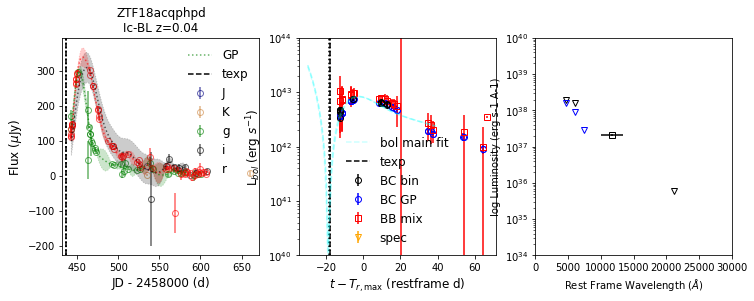

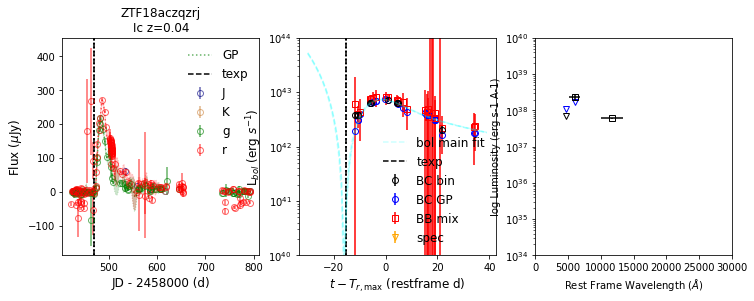

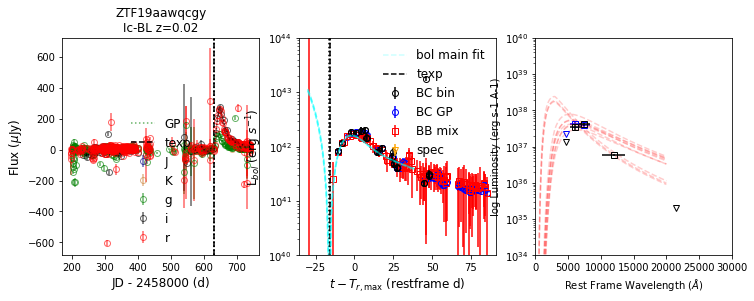

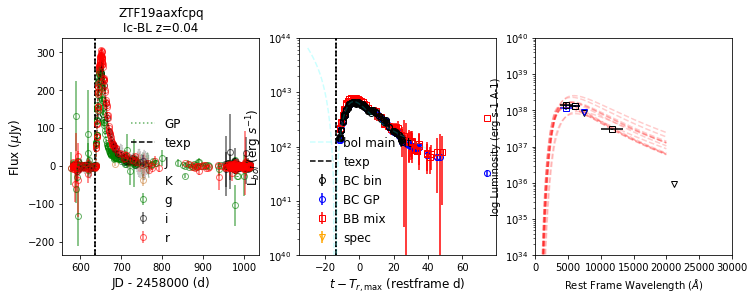

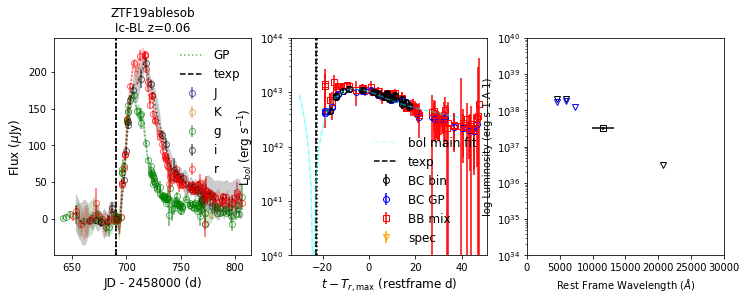

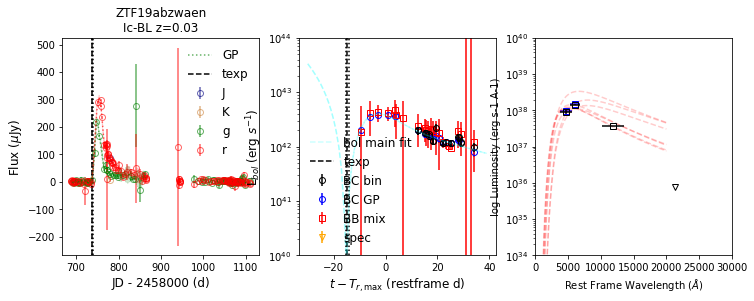

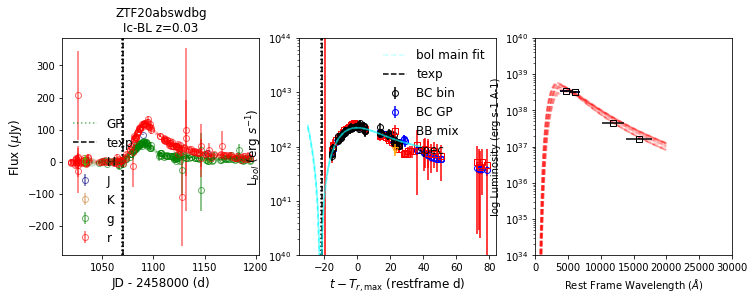

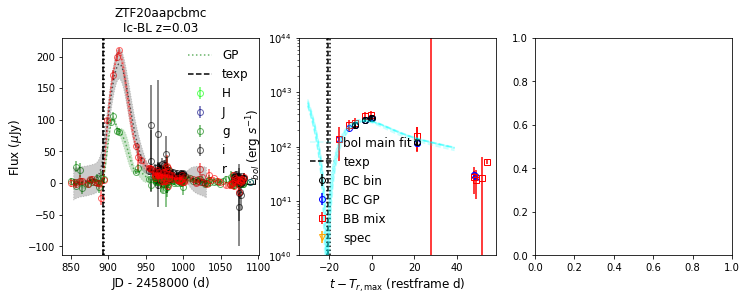

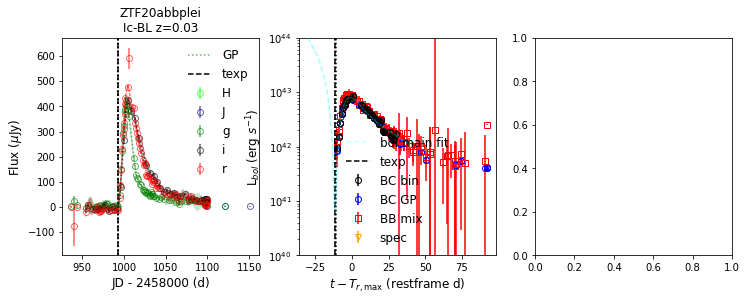

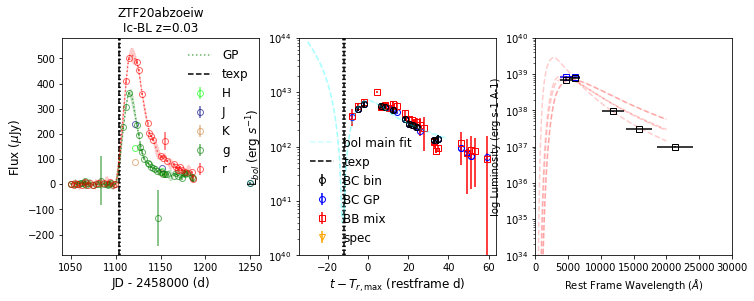

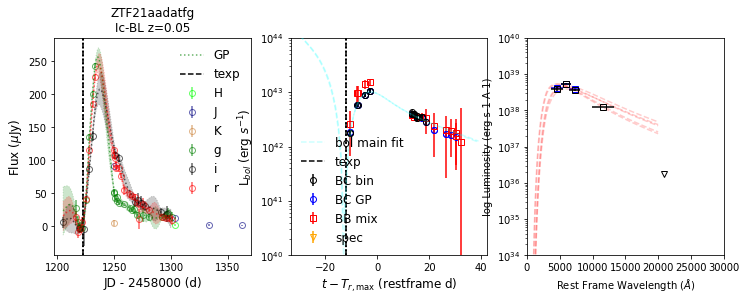

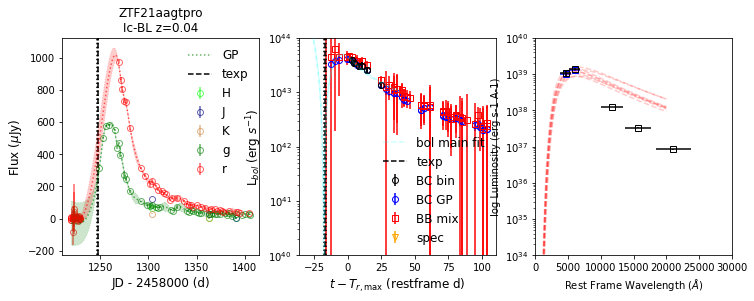

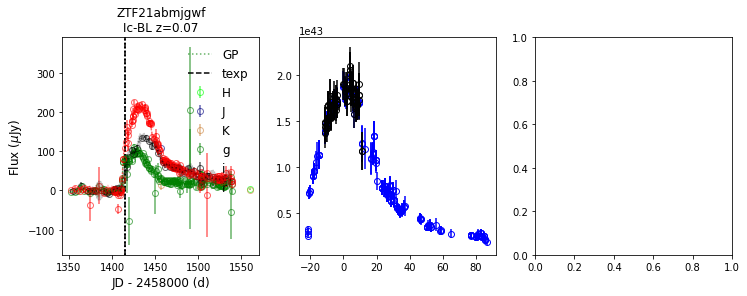

In [169]:
for objid in snlist:
        
    # for single object
    ztfp.parse_meta_all(ztfp.kwargs, objid)
    ztfp.data[objid] = snerun.snobject(objid, z=ztfp.z, ra=ztfp.ra, dec=ztfp.dec,
                mkwebv=ztfp.mkwebv, hostebv=ztfp.hostebv, sntype=ztfp.sntype.replace('?',''),
                dm=ztfp.dm, jdpeak=ztfp.jdpeak)
    
    # get ZTf forced phot from local
    ztfp.data[objid].get_fp_ztf()
    
    # get NIR phot from local
    if not os.path.exists('ZTF_NIR_photometry/%s_phot_table.txt'%objid): 
        print ('no nir phot found for %s, skipped...' % objid)
        continue
    ztfp.data[objid].get_external_phot('ZTF_NIR_photometry/%s_phot_table.txt'%objid, source='nir')
    
    # run GP
    ztfp.data[objid].run_gp(gp_bands=['r','g','i'])
    ztfp.data[objid].set_peak_gp('r')

    # run Arnett fits
    ztfp.data[objid].lyman_bol()
    ztfp.data[objid].run_fit('bol_main', fit_methods=['arnett_fit_taum_texp'])
    
    # show them
    ztfp.data[objid].fig,(ztfp.data[objid].ax, ztfp.data[objid].ax4, ztfp.data[objid].ax5) = plt.subplots(1,3,figsize=(12,4))
    
    # flux plot
    ztfp.data[objid]._ax(
        ax_ystyle='original', ax_xstyle='jd',
        plot_bands=None, show_title=True, show_legend=True
    )
    
    # bolometric lc plot
    ztfp.data[objid]._ax4(
        make_bol=['lyman', 'bb', 'spec'], show_legend=True, sed_color_interp_mix=True,
        show_fits=True, verose=False, ax4_ylim=[1e40,1e44],
    )
    
    # sed fitting, for the first epoch with NIR data
    if len(ztfp.data[objid].lc.query('mag<99 and filter in ["J", "H", "K"]')) == 0: continue
    phase = (ztfp.data[objid].lc.query('mag<99 and filter in ["J", "H", "K"]')['jdobs'].to_list()[0] - ztfp.data[objid].t0)
    ztfp.data[objid]._ax5(phase, sed_bands=['g','r','i','J','H','K'], tdbin=5, ax5_xlim=[0,30000], ax5_ylim=[1e34,1e40])


In [7]:
ztfp.add_subset()
ztfp.pars=[]
ztfp.add_parameter(parname='objid')
ztfp.add_parameter(parname='tpeak', filt1='r')
ztfp.add_parameter(parname='Mag', filt1='r', phase1=0)
ztfp.add_parameter(parname='Mag', filt1='g', phase1=0)
ztfp.add_parameter(parname='texp', expwith='bol')
ztfp.add_parameter(parname='mni')
ztfp.add_parameter(parname='taum')
tab = ztfp.table(syntax=None, tablename=None)
print (tab)

objid & None & Mag_r_0 & Mag_g_0 & None & mni & taum \\ 
ZTF18acpeekw & - & None & None & - & - & - \\ 
ZTF18acbwxcc & - & -19.207 (0.096) & -18.975 (0.098) & - & - & - \\ 
ZTF18acaimrb & - & -18.607 (0.102) & -18.184 (0.112) & - & - & - \\ 
ZTF18abklarx & - & -18.338 (0.098) & -18.301 (0.098) & - & - & - \\ 
ZTF20aazkjfv & - & -18.259 (0.095) & -17.311 (0.102) & - & - & - \\ 
ZTF21aafnunh & - & -19.352 (0.096) & None & - & - & - \\ 
ZTF18acqphpd & 2458456.006 & -18.64 (0.125) & -18.47 (0.129) & -19.263$_{-0.337}^{0.578}$ & 0.397$_{-0.006}^{0.003}$ & 14.556$_{-0.325}^{0.284}$ \\ 
ZTF18aczqzrj & 2458487.014 & -18.713 (0.095) & -18.328 (0.096) & -16.551$_{-0.257}^{0.562}$ & 0.302$_{-0.004}^{0.004}$ & 11.879$_{-0.311}^{0.391}$ \\ 
ZTF19aawqcgy & 2458647.759 & -17.098 (0.098) & -16.117 (0.116) & -16.389$_{-0.21}^{0.379}$ & 0.068$_{-0.001}^{0.001}$ & 12.084$_{-0.193}^{0.315}$ \\ 
ZTF19aaxfcpq & 2458650.727 & -18.478 (0.097) & -18.259 (0.098) & -14.056$_{-0.042}^{0.073}$ & 0.228$_{-0.001}^{0